In [1]:
# import os
from torch.utils.data import Dataset
import numpy as np
import os
from scipy import interpolate
from einops import rearrange
import json
import csv
import torch
from PIL import Image
from pathlib import Path
import torchvision.transforms as transforms
from transformers import CLIPTextModel, CLIPVisionModel

In [2]:
def normalize(x, mean=None, std=None):
    mean = np.mean(x) if mean is None else mean
    std = np.std(x) if std is None else std
    return (x - mean) / (std * 1.0)

def identity(x):
    return x

def list_get_all_index(list, value):
    return [i for i, v in enumerate(list) if v == value]


def pad_to_patch_size(x, patch_size):
    # pad the last dimension only
    padding_config = [(0,0)] * (x.ndim - 1) + [(0, patch_size-x.shape[-1]%patch_size)]
    return np.pad(x, padding_config, 'wrap')

def get_stimuli_list(root, sub):
    sti_name = []
    path = os.path.join(root, 'Stimuli_Presentation_Lists', sub)
    folders = os.listdir(path)
    folders.sort()
    for folder in folders:
        if not os.path.isdir(os.path.join(path, folder)):
            continue
        files = os.listdir(os.path.join(path, folder))
        files.sort()
        for file in files:
            if file.endswith('.txt'):
                sti_name += list(np.loadtxt(os.path.join(path, folder, file), dtype=str))

    sti_name_to_return = []
    for name in sti_name:
        if name.startswith('rep_'):
            name = name.replace('rep_', '', 1)
        sti_name_to_return.append(name)
    return sti_name_to_return

def pad_fmri_to_target(fmri_data, target_samples, target_voxels):
    # Padding for the first dimension (samples)
    if fmri_data.shape[0] < target_samples:
        sample_pad_size = target_samples - fmri_data.shape[0]
        fmri_data = np.pad(fmri_data, ((0, sample_pad_size), (0, 0)), mode='constant')
    elif fmri_data.shape[0] > target_samples:
        fmri_data = fmri_data[:target_samples, :]  # Crop to target sample size

    # Padding for the second dimension (voxels)
    if fmri_data.shape[1] < target_voxels:
        voxel_pad_size = target_voxels - fmri_data.shape[1]
        fmri_data = np.pad(fmri_data, ((0, 0), (0, voxel_pad_size)), mode='constant')
    elif fmri_data.shape[1] > target_voxels:
        fmri_data = fmri_data[:, :target_voxels]  # Crop to target voxel size

    return fmri_data



In [ ]:
cfg = {
    'model': {
        'max_seq_len': 512,  
        'hidden_size': 512,  
        'num_attention_heads': 8,
        'dim_feedforward': 2048,
        'activation': 'relu',
        'dropout': 0.1,
        'num_layers': 6
    }
}

In [ ]:
import torch
import torch.nn as nn

class FMRITransformerEncoder(nn.Module):
    def __init__(self, cfg: dict):
        super().__init__()
        self.cfg = cfg
        
        max_seq_len = max(cfg['model']['max_seq_len'], cfg['model']['hidden_size'])
        self.positional_embedding = nn.Embedding(max_seq_len, cfg['model']['hidden_size'])
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg['model']['hidden_size'],
            nhead=cfg['model']['num_attention_heads'],
            dim_feedforward=cfg['model']['dim_feedforward'],
            activation=cfg['model']['activation'],
            dropout=cfg['model']['dropout'],
            batch_first=True,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=cfg['model']['num_layers'])
        self.fc = nn.Linear(cfg['model']['hidden_size'], 512)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, num_voxels = x.size()
        print('Number of voxels:', num_voxels)

        x = x.unsqueeze(1) 
        
        positional_embedding = self.positional_embedding(torch.arange(num_voxels, device=x.device)).unsqueeze(0)
        positional_embedding = positional_embedding.expand(batch_size, num_voxels, -1)
        x = x + positional_embedding
        x = self.encoder(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x 


In [ ]:
# from transformers import CLIPModel
from torchvision import transforms, models

class BOLD5000_ResNet_dataset(Dataset):
    def __init__(self, fmri, image, fmri_transform=identity, image_transform=identity, num_voxels=0, fmri_encoder=None):
        # self.fmri = fmri
        self.fmri = torch.tensor(fmri)
        self.image = image
        self.fmri_transform = fmri_transform
        self.image_transform = image_transform
        self.num_voxels = num_voxels
        
        self.image = np.transpose(image, (0, 3, 1, 2))
        self.image = self.image.astype(np.float32) / 255.0
        
        # Use a pre-trained ResNet model (ResNet18 for example)
        self.resnet_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet_model.eval()  
        
        self.resnet_model = torch.nn.Sequential(*list(self.resnet_model.children())[:-1])
        
        inputs = torch.from_numpy(self.image)
        self.image_embeddings = self.resnet_model(inputs).squeeze(-1).squeeze(-1) 
        
        # print(f"Image embeddings shape: {self.image_embeddings.shape}")
        
        # fMRI encoder (transformer model)
        self.fmri_encoder = fmri_encoder

    def __len__(self):
        return len(self.fmri)
    
    def __getitem__(self, idx):
        fmri = self.fmri[idx]
        fmri = self.fmri_transform(fmri)
        
        fmri_embedding = self.fmri_encoder(fmri.unsqueeze(0)) 
        
        # img = self.image[idx]
        # img = self.image_transform(img)  # Apply image transformation
        
        return {
            'fmri': fmri_embedding,  
            'image': self.image_embeddings[idx].unsqueeze(0)  
        }

def create_BOLD5000_dataset(path='../data/BOLD5000', patch_size=16, fmri_transform=None,
                            image_transform=None, subjects=['CSI1', 'CSI2', 'CSI3', 'CSI4'], 
                            include_nonavg_test=False, include_image_caption=False, include_image_clip=False):
    roi_list = ['EarlyVis', 'LOC', 'OPA', 'PPA', 'RSC']
    fmri_path = os.path.join(path, 'BOLD5000_GLMsingle_ROI_betas/py')
    img_path = os.path.join(path, 'BOLD5000_Stimuli')
    imgs_dict = np.load(os.path.join(img_path, 'Scene_Stimuli/Presented_Stimuli/img_dict.npy'), allow_pickle=True).item()
    
    repeated_imgs_list = np.loadtxt(os.path.join(img_path, 'Scene_Stimuli', 'repeated_stimuli_113_list.txt'), dtype=str)

    fmri_files = [f for f in os.listdir(fmri_path) if f.endswith('.npy')]
    fmri_files.sort()

    fmri_train_major = []
    fmri_test_major = []
    img_train_major = []
    img_test_major = []
    caption_train_major = []
    caption_test_major = []

    for sub in subjects:
        # load fmri
        fmri_data_sub = []
        for roi in roi_list:
            for npy in fmri_files:
                if npy.endswith('.npy') and sub in npy and roi in npy:
                    fmri_data_sub.append(np.load(os.path.join(fmri_path, npy)))
        fmri_data_sub = np.concatenate(fmri_data_sub, axis=-1)  # concatenate all rois
        fmri_data_sub = normalize(pad_to_patch_size(fmri_data_sub, patch_size))
      
        # load image
        img_files = get_stimuli_list(img_path, sub)
        img_data_sub = [imgs_dict[name] for name in img_files]
        # print("Image data sub shape: ", np.shape(img_data_sub))

        # split train/test
        test_idx = [list_get_all_index(img_files, img) for img in repeated_imgs_list]
        test_idx = [i for i in test_idx if len(i) > 0]  # remove empty list for CSI4
        test_fmri = np.stack([fmri_data_sub[idx].mean(axis=0) for idx in test_idx])
        test_img = np.stack([img_data_sub[idx[0]] for idx in test_idx])

        test_idx_flatten = []
        for idx in test_idx:
            test_idx_flatten += idx  
        if include_nonavg_test:
            test_fmri = np.concatenate([test_fmri, fmri_data_sub[test_idx_flatten]], axis=0)
            test_img = np.concatenate([test_img, np.stack([img_data_sub[idx] for idx in test_idx_flatten])], axis=0)

        train_idx = [i for i in range(len(img_files)) if i not in test_idx_flatten]
        train_img = np.stack([img_data_sub[idx] for idx in train_idx])
        train_fmri = fmri_data_sub[train_idx]
        train_fmri = pad_fmri_to_target(train_fmri, target_samples=4803, target_voxels=512)
        test_fmri = pad_fmri_to_target(test_fmri, target_samples=4803, target_voxels=512)

        fmri_train_major.append(train_fmri)
        fmri_test_major.append(test_fmri)
        img_train_major.append(train_img)
        img_test_major.append(test_img)

    fmri_train_major = np.concatenate(fmri_train_major, axis=0)[:200,:]
    fmri_test_major = np.concatenate(fmri_test_major, axis=0)[:100,:]
    img_train_major = np.concatenate(img_train_major, axis=0)[:200,:]
    img_test_major = np.concatenate(img_test_major, axis=0)[:100,:]

    # print(img_train_major.shape)

    num_voxels = fmri_train_major.shape[-1]
    
    fmri_enc = FMRITransformerEncoder(cfg)  
    
    
    if include_image_clip: 
        return (BOLD5000_ResNet_dataset(
                    fmri_train_major, img_train_major, fmri_transform, image_transform, num_voxels, fmri_encoder=fmri_enc), 
                BOLD5000_ResNet_dataset(
                    fmri_test_major, img_test_major, fmri_transform, image_transform, num_voxels, fmri_encoder=fmri_enc))
    else:  
        return (BOLD5000_dataset(fmri_train_major, img_train_major, fmri_transform, image_transform, num_voxels),
                BOLD5000_dataset(fmri_test_major, img_test_major, fmri_transform, image_transform, num_voxels))
           

class BOLD5000_dataset(Dataset):
    def __init__(self, fmri, image, fmri_transform=identity, image_transform=identity, num_voxels=0):
        self.fmri = fmri
        self.image = image
        self.fmri_transform = fmri_transform
        self.image_transform = image_transform
        self.num_voxels = num_voxels
    
    def __len__(self):
        return len(self.fmri)
    
    def __getitem__(self, index):
        fmri = self.fmri[index]
        img = self.image[index] / 255.0
        fmri = np.expand_dims(fmri, axis=0) 
        return {'fmri': self.fmri_transform(fmri), 'image': self.image_transform(img)}

class BOLD5000_CLIP_dataset(Dataset):
    def __init__(self, fmri, image, fmri_transform=identity, image_transform=identity, num_voxels=0, fmri_encoder=None):
        self.fmri = fmri
        self.image = image
        self.fmri_transform = fmri_transform
        self.image_transform = image_transform
        self.num_voxels = num_voxels
        
        
        resize_transform = transforms.Resize((224, 224)) 
        self.image = np.transpose(image, (0, 3, 1, 2))  
        self.image = np.array([resize_transform(torch.from_numpy(img)) for img in self.image])

        self.image = self.image.astype(np.float32) / 255.0
        
        
        self.image_encoder = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")  
        self.image_encoder = torch.quantization.quantize_dynamic(self.image_encoder, dtype=torch.qint8)
        
        inputs = torch.from_numpy(self.image)
        self.image_embeddings = self.image_encoder.get_image_features(pixel_values=inputs)
        
        # print(f"Image embeddings shape: {self.image_embeddings.shape}")
        
        self.fmri_encoder = fmri_encoder

    def __len__(self):
        return len(self.fmri)
    
    def __getitem__(self, idx):
        fmri = self.fmri[idx]
        fmri = self.fmri_transform(fmri)
        
        fmri_embedding = self.fmri_encoder(fmri.unsqueeze(0))  
        
        img = self.image[idx]
        img = self.image_transform(img)  
        
        return {
            'fmri': fmri_embedding, 
            'image': self.image_embeddings[idx] 
        }

In [ ]:
data_path = '/home2/prateekj/tether-assgn/data/BOLD5000'
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

fmri_encoder = FMRITransformerEncoder(cfg)

train_dataset, test_dataset = create_BOLD5000_dataset(
    path=data_path,
    patch_size=16,
    fmri_transform=lambda x: torch.tensor(x, dtype=torch.float32),
    image_transform=image_transform,
    subjects=['CSI1', 'CSI2', 'CSI3', 'CSI4'],
    include_image_clip=True  
)
# print(train_dataset)

# print(train_dataset['fmri'].shape, train_dataset['image'].shape)

sample_train = train_dataset[50] 
print("FMRI Embedding shape:", sample_train['fmri'].clone().detach().shape)
print("Image Embedding shape:", sample_train['image'].shape)


/tmp/ipykernel_21187/1685143796.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fmri_transform=lambda x: torch.tensor(x, dtype=torch.float32),


Number of voxels: 512
FMRI Embedding shape: torch.Size([1, 512])
Image Embedding shape: torch.Size([1, 512])


In [7]:
print(f"Number of samples in the train dataset: {len(train_dataset)}")
print(f"Number of samples in the test dataset: {len(test_dataset)}")

Number of samples in the train dataset: 200
Number of samples in the test dataset: 100


(4803, 2800)
(4803, 2800)
(4803, 2800)
(4803, 2800)
Sample from Train Dataset:
FMRI data shape: torch.Size([1, 2800])
Image data shape: torch.Size([3, 224, 224])

Sample from Test Dataset:
FMRI data shape: torch.Size([1, 2800])
Image data shape: torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.5702832].


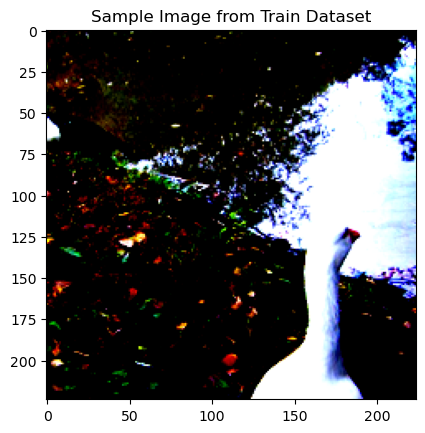

In [ ]:
data_path = '/home2/prateekj/tether-assgn/data/BOLD5000' 
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset, test_dataset = create_BOLD5000_dataset(
    path=data_path,
    patch_size=16,
    fmri_transform=lambda x: torch.tensor(x, dtype=torch.float32),
    image_transform=image_transform,
    subjects=['CSI1', 'CSI2', 'CSI3', 'CSI4'],
    include_nonavg_test=False,
    include_image_caption=False
)

print("Sample from Train Dataset:")
sample_train = train_dataset[50]  
print("FMRI data shape:", sample_train['fmri'].shape)
print("Image data shape:", sample_train['image'].shape)

print("\nSample from Test Dataset:")
sample_test = test_dataset[0]  
print("FMRI data shape:", sample_test['fmri'].shape)
print("Image data shape:", sample_test['image'].shape)


import matplotlib.pyplot as plt

plt.imshow(sample_train['image'].permute(1, 2, 0)) 
plt.title("Sample Image from Train Dataset")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3262744].


Sample from Train Dataset:
FMRI data shape: torch.Size([1, 2800])
Image data shape: torch.Size([3, 224, 224])

Sample from Test Dataset:
FMRI data shape: torch.Size([1, 2800])
Image data shape: torch.Size([3, 224, 224])


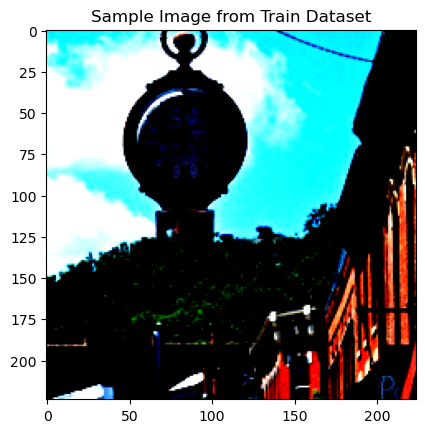

In [6]:
print("Sample from Train Dataset:")
sample_train = train_dataset[10]  # Sample a single entry
print("FMRI data shape:", sample_train['fmri'].shape)
print("Image data shape:", sample_train['image'].shape)

print("\nSample from Test Dataset:")
sample_test = test_dataset[0]  # Sample a single entry
print("FMRI data shape:", sample_test['fmri'].shape)
print("Image data shape:", sample_test['image'].shape)

# You can visualize a sample image if needed using matplotlib
import matplotlib.pyplot as plt

plt.imshow(sample_train['image'].permute(1, 2, 0))  # Reorder tensor dimensions for visualization
plt.title("Sample Image from Train Dataset")
plt.show()
